# Doc2Vec (1.5 балла)

**Данные:** корпус русской литературной баллады 1840 гг. (источник: https://dataverse.pushdom.ru/dataset.xhtml?persistentId=doi:10.31860/openlit-2021.9-C003, папка ballads40 на я.диске)

**Задание:**


1.   Предобработайте тексты так, как это необходимо для нормальной работы Doc2Vec;
2.   Обучите модель Doc2Vec на текстах;
3.   Выберите пару авторов. При помощи TSNE визуализируйте эмбеддинги их текстов.

**Дополнительное задание:** среди авторов есть личности, скрытые за аббревиатурами. Используя векторную близость, попробуйте найти, с текстами каких авторов больше всего схожи анонимные баллады (достаточно выбрать одного анонимного автора). (1 балл)



In [ ]:
#!pip install gensim #перезапустить среду

In [ ]:
import numpy as np

In [ ]:
import chardet

In [ ]:
from pymystem3 import Mystem
mystem = Mystem()

import nltk
from nltk.tokenize import word_tokenize
from nltk import download
download('punkt_tab')
download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from zipfile import ZipFile

path_to_archive = '/content/ballads40.zip'

def texts_from_zip(path_to_archive):
  texts = []
  with ZipFile(path_to_archive) as zip_archive:
    for name in zip_archive.namelist():
      if '.txt' in name:
        text = zip_archive.read(name)
        encoding = chardet.detect(text) #оказалось, что у текстов разная кодировка
        text = text.decode(encoding['encoding'])
        text = mystem.lemmatize(text.lower())
        text = [word for word in text if word not in stop_words and word[0].isalpha()] # чистим от стоп-слов и пунктуации
        text = ' '.join(text)
        texts.append(text)
  return texts

def get_filenames(path_to_archive):
  names = []
  with ZipFile(path_to_archive) as zip_archive:
    for name in zip_archive.namelist():
      if '.txt' in name:
        names.append(name.split('/')[1])
  return names

In [ ]:
names = get_filenames(path_to_archive)
texts = texts_from_zip(path_to_archive)

In [ ]:
texts[:5] #какой-то странный прикол, каждый второй элемент списка -- mac os x [...]. видимо, что то произошло при разархивировании

['тенистый прохладный брайнгельский лесок плескаться грета душистый ветерок берег пестреть усеивать цветок ходить девица рыбка стадо конь разыгрываться пред башня замок дальтонский стоять стена замок башня стоять девица душа радость сердце царица тенистый прохладный брайнгельский лесок плескаться грета душистый ветерок туда эдмонд девица сказать трон променивать ах солнце молвить тоска знать твой гость часовой тайна подумать солнце высоко пора девица ехать далеко тенистый прохладный брайнгельский лесок плескаться грета душистый ветерок милый сан надежда чаровать сердце горячий сердце искать ловчий верно любить король охотничий рог твой порука девица рог ловчий солнце встречать полночь ловец полуночный сзывать тенистый прохладный брайнгельский лесок плескаться грета душистый ветерок б милый вера любовь прильнуть сестра твой изголовье рыцарь знать говорить твой шлем красноперый твой бранный наряд девица девица шлем кольчуга скрывать враг добрый друг тенистый прохладный брайнгельский лесо

In [ ]:
texts = list(filter(lambda x: x != 'mac os x attr com apple quarantine q chrome', texts))
names = list(filter(lambda x: x != 'ballads40', names))
#texts[:5] #другое дело :)

In [ ]:
names = [name.split('_', 2)[2].split('.')[0] for name in names]

In [ ]:
print(len(texts))
print(len(names))

189
189


In [ ]:
import gensim

In [ ]:
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
texts_for_doc2vec = [re.findall(r'\w+', i) for i in texts]
docs_for_doc2vec = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts_for_doc2vec)]

In [ ]:
d2v_model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=5)

In [ ]:
d2v_model.build_vocab(docs_for_doc2vec)

In [ ]:
%%time
d2v_model.train(docs_for_doc2vec, total_examples=d2v_model.corpus_count, epochs=50)

CPU times: user 5.6 s, sys: 72.5 ms, total: 5.67 s
Wall time: 6.02 s


In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
writers_indices = [i for i, name in enumerate(names) if name == 'Nekrasov' or name == 'Lermontov' or name == 'Fet' or name == 'Sokolova']
writers_vectors = [d2v_model.dv[i] for i in writers_indices]
writers_names = [names[i] for i in writers_indices]

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
writers_vec_2d = tsne.fit_transform(np.array(writers_vectors))

In [ ]:
colour_map = {'Nekrasov': "hotpink", 'Lermontov': "lightskyblue", 'Sokolova': 'gold', 'Fet': 'mediumpurple'}
colours = [colour_map[name] for name in writers_names]

<ipython-input-20-21c028c95e03>:4: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 41
  plt.legend(handles=[Patch(color=colour, label=author) for author, colour in colour_map.items()],


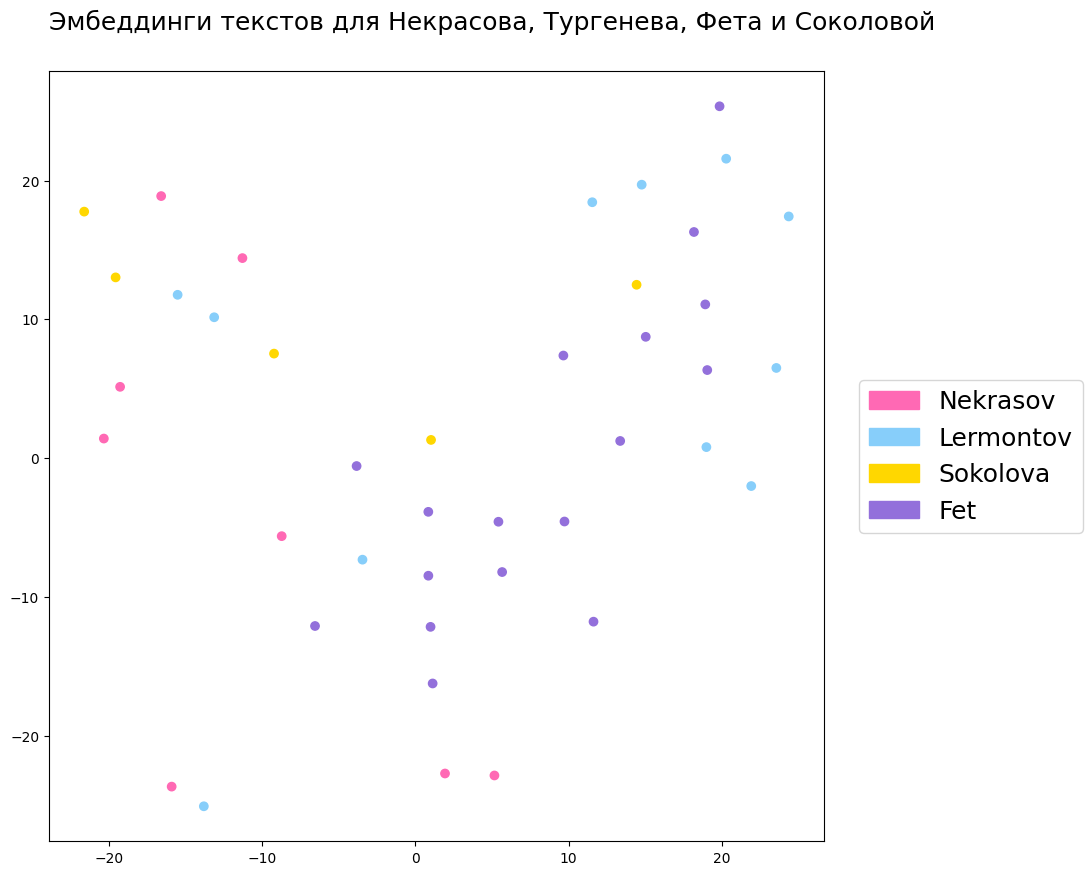

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = plt.scatter(writers_vec_2d[:,0], writers_vec_2d[:,1],
                      c=colours)
plt.legend(handles=[Patch(color=colour, label=author) for author, colour in colour_map.items()],
           labels=writers_names,
           prop={'size': 18},
           loc='center right',
           bbox_to_anchor=(1.35, 0.5))
plt.title('Эмбеддинги текстов для Некрасова, Тургенева, Фета и Соколовой',
          size=18,
          loc='left',
          pad=30)
plt.show()

Анонимный автор. Я взяла A_S

In [ ]:
print(names.index('A_S'))
anonymous_vector = d2v_model.infer_vector(texts_for_doc2vec[159])
for doc_id, sim in d2v_model.dv.most_similar([anonymous_vector], topn=5):
  print(f'{names[doc_id]}, косинусная близость: {sim}')

159
A_S, косинусная близость: 0.8909333944320679
Grigoryev, косинусная близость: 0.7654181718826294
Fet, косинусная близость: 0.7080225348472595
Polonsky, косинусная близость: 0.7009692788124084
Ogarev, косинусная близость: 0.6850404739379883


Первый текст – это и есть сам текст A_S, потому что модель и так на нём тренировалась. Поэтому наиболее похож текст анонимного автора на текст Григорьева (хотя разница с остальными не особо большая)

# Полносвязные, рекуррентные нейросети и трансформеры

**Данные: здесь и далее необходимо использовать учебный корпус для анализа тональности** (источник: https://www.kaggle.com/datasets/prishasawhney/sentiment-analysis-evaluation-dataset, файл sentiment_analysis_evaluation.csv на диске).

**Задание:** вставьте недостающие фрагменты кода на месте # ВАШ КОД ЗДЕСЬ.


## FFNN (1.5 балла)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/sentiment_analysis_evaluation.csv')

In [ ]:
set(df['Label'].tolist())

{'negative', 'positive'}

In [ ]:
import torch
from torch import nn

In [ ]:
import torch.optim as optim

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
LABELS = {'negative': 0, 'positive': 1}

In [ ]:
REVERSE_LABELS = {v: k for k, v in LABELS.items()}

In [ ]:
def label_to_index(label):
  return torch.LongTensor([LABELS[label]])

In [ ]:
vocabulary = set()
lemmatized_texts = []
encoded_labels = []


for n, row in df.iterrows():

  doc = nlp(row['Text'])
  lemmas = []

  for token in doc:
    lemma = token.lemma_
    lemmas.append(lemma)
    vocabulary.add(lemma)

  encoded_labels.append(label_to_index(row['Label']))
  lemmatized_texts.append(lemmas)

In [ ]:
vocabulary = list(vocabulary)

In [ ]:
indexes = {word: ind for ind, word in enumerate(vocabulary)}

In [ ]:
def get_text_vector(text):
  current_indexes = [indexes[token] for token in text]
  current_tensor = torch.zeros(len(vocabulary))
  current_tensor[current_indexes] = 1
  return current_tensor.view(1, -1)

In [ ]:
all_categories = list(LABELS.keys())

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
class FFNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(FFNN, self).__init__()

    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu1 = nn.ReLU()

    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.relu2 = nn.ReLU()

    self.fc3 = nn.Linear(hidden_dim, output_dim)

    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu1(out)

    out = self.fc2(out)
    out = self.relu2(out)

    out = self.fc3(out)

    return self.softmax(out)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lemmatized_texts,
                                                    encoded_labels,
                                                    stratify=encoded_labels,
                                                    test_size=0.2,
                                                    shuffle=True)

In [ ]:
input_dim = len(vocabulary)
hidden_dim = 50
output_dim = len(all_categories)
num_epochs = 200

ffnn = FFNN(input_dim, hidden_dim, output_dim)
ffnn.to(device)

loss_function = nn.CrossEntropyLoss() #как я поняла, кросс энтропию часто используют для классификации
optimizer = optim.SGD(ffnn.parameters(), lr=0.001) #из notebooks с занятий

In [ ]:
from tqdm import tqdm

In [ ]:
import random

In [ ]:
losses = []

for epoch in tqdm(range(num_epochs)):

  epoch_loss = 0

  texts_and_labels = list(zip(X_train, y_train))
  random.shuffle(texts_and_labels)

  for current_text, current_label in texts_and_labels:

    optimizer.zero_grad()

      # кодируем имя и категорию, превращая их в тензоры (1 тензор - 1 пример (1 слово), таким образом кодируем имя и индекс категории)
    text_tensor = get_text_vector(current_text)
    label_tensor = current_label.long()
      # forward pass: обновляем веса и получаем вероятности классов для слова
    probs = ffnn(text_tensor.to(device))

      # считаем значение функции потерь и добавляем его к общему лоссу этой эпохи
    loss = loss_function(probs, label_tensor.to(device))
    epoch_loss += loss.item() #запоминаем значение тренировочного лосса для дальнейшей отрисовки

      # backward pass: распространяем ошибку обратно, чтобы проапдейтить веса
    loss.backward()

      # Апдейтим веса
    optimizer.step()

  losses.append(epoch_loss)
    # перед следующей эпохой зануляем лосс
  epoch_loss = 0

100%|██████████| 200/200 [00:47<00:00,  4.18it/s]


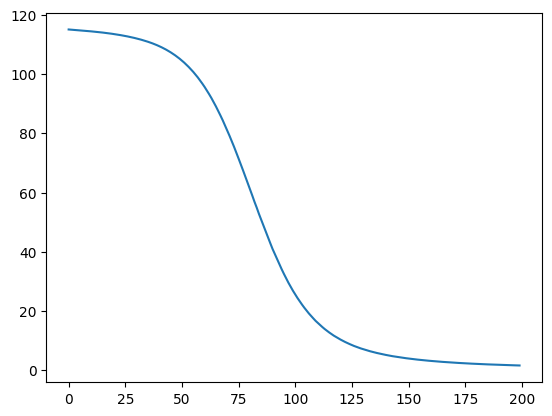

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
from sklearn.metrics import classification_report

predictions = []
original_labels = []

with torch.no_grad():
  for text, label in zip(X_test, y_test):
    line_tensor = get_text_vector(text)
    category_tensor = torch.tensor(label.long())

    probs = ffnn(line_tensor) #получаем вероятности каждого класса
    predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
    original_labels.append(label)

<ipython-input-46-a5e954df0e62>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  category_tensor = torch.tensor(label.long())


In [ ]:
print(classification_report(original_labels, predictions))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.85      0.74      0.79        23

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.79        42
weighted avg       0.79      0.79      0.79        42



## RNN (2 балла)

За усложнение архитектуры (использование дополнительных слоев, LSTM-блоков вместо обычных RNN) может быть начислен 1 дополнительный балл.

In [ ]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
class SentimentDataset(Dataset):
  def __init__(self, texts, labels):
    self.texts = texts
    self.labels = labels

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, ind):
    return self.texts[ind], self.labels[ind]

In [ ]:
max_len = max([len(text) for text in lemmatized_texts])

In [ ]:
max_len

19

In [ ]:
padded_indexed_texts = []

for text in lemmatized_texts:
  indexes = []

  for word in text:
    indexes.append(vocabulary.index(word)+1)

  if len(indexes) < max_len:
    # padding до максимальной длины
    indexes.extend([0]*(max_len-len(indexes)))

  padded_indexed_texts.append(torch.FloatTensor(indexes))

In [ ]:
all(len(l) == max_len for l in padded_indexed_texts)

True

In [ ]:
encoded_labels_rnn = torch.LongTensor([LABELS[label] for label in df['Label']])

In [ ]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded_indexed_texts,
                                                                    encoded_labels_rnn,
                                                                    stratify=encoded_labels_rnn,
                                                                    test_size=0.2,
                                                                    shuffle=True)

In [ ]:
#переделано под LSTM
class RecurrentNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(RecurrentNN, self).__init__()
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    self.hidden_to_output = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, hidden):
    lstm_out, hidden = self.lstm(x, hidden)
    hidden_tensor = hidden[0].permute(1, 0, 2).squeeze(1)
    output = self.hidden_to_output(hidden_tensor)
    return output, hidden

  def init_hidden(self, batch_size):
    return (torch.zeros(1, batch_size, self.hidden_dim).to(device), #видимо для LSTM нужно передавать кортеж с дублирующимися state tensors
            torch.zeros(1, batch_size, self.hidden_dim).to(device))

In [ ]:
batch_size = 16
input_dim = len(vocabulary)
hidden_dim = 100
output_dim = len(all_categories)

In [ ]:
train_dataset = SentimentDataset(X_train_rnn, y_train_rnn)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model_rnn = RecurrentNN(max_len, hidden_dim, output_dim).to(device)
loss_rnn = nn.CrossEntropyLoss()
optim_rnn = optim.AdamW(model_rnn.parameters(), lr=0.001)

In [ ]:
losses = []
rnn_epochs = 100

for epoch in tqdm(range(rnn_epochs)):

  epoch_loss = 0
#проблема с постоянным batch_size :(
  for texts, labels in train_loader:
    current_batch_size = texts.size(0)
    hidden = model_rnn.init_hidden(current_batch_size)

      # Очищаем градиент, аккумулированный на предыдущих этапах
    optim_rnn.zero_grad()

      # кодируем имя и категорию, превращая их в тензоры
    line_tensor = texts.to(device)
    category_tensor = labels.long().to(device)

      # forward pass: идем по каждой букве, обновляем веса и получаем вероятности классов для слова

    output, hidden = model_rnn(line_tensor.unsqueeze(1), hidden)

    output = output.squeeze(1) #для функции потерь

      # считаем значение функции потерь и добавляем его к общему лоссу этой эпохи
    loss = loss_rnn(output, category_tensor)
    epoch_loss += loss.item()

      # backward pass: распространяем ошибку обратно, чтобы проапдейтить веса
    loss.backward()

      # Апдейтим веса
    optim_rnn.step()

  losses.append(epoch_loss/len(train_loader))

  print('Epoch {0}, loss {1}'.format(epoch, epoch_loss/len(train_loader)))


  epoch_loss = 0

  3%|▎         | 3/100 [00:00<00:07, 13.77it/s]

Epoch 0, loss 0.6804683587767861
Epoch 1, loss 0.6207824728705666
Epoch 2, loss 0.5895945483987982
Epoch 3, loss 0.5743252580816095


  8%|▊         | 8/100 [00:00<00:04, 19.31it/s]

Epoch 4, loss 0.5484454740177501
Epoch 5, loss 0.5206683061339639
Epoch 6, loss 0.5061310665173964
Epoch 7, loss 0.4788165336305445
Epoch 8, loss 0.47081792625513946
Epoch 9, loss 0.4521257064559243


 14%|█▍        | 14/100 [00:00<00:03, 24.80it/s]

Epoch 10, loss 0.44576252048665826
Epoch 11, loss 0.4276929931207137
Epoch 12, loss 0.3906316567551006
Epoch 13, loss 0.3815987462347204
Epoch 14, loss 0.3806863156231967
Epoch 15, loss 0.3862876133485274
Epoch 16, loss 0.36556322601708496


 22%|██▏       | 22/100 [00:00<00:02, 28.44it/s]

Epoch 17, loss 0.34762092612006446
Epoch 18, loss 0.34968135438182135
Epoch 19, loss 0.33187852935357526
Epoch 20, loss 0.33533486452969635
Epoch 21, loss 0.3234426582401449
Epoch 22, loss 0.3078549680384723
Epoch 23, loss 0.2870772508057681


 30%|███       | 30/100 [00:01<00:02, 30.00it/s]

Epoch 24, loss 0.2851532602852041
Epoch 25, loss 0.2880152436819943
Epoch 26, loss 0.28164870224215766
Epoch 27, loss 0.26797992397438397
Epoch 28, loss 0.2546958733688701
Epoch 29, loss 0.23592753572897476
Epoch 30, loss 0.2398292381655086


 36%|███▌      | 36/100 [00:01<00:02, 29.10it/s]

Epoch 31, loss 0.22548197345300156
Epoch 32, loss 0.2195284298875115
Epoch 33, loss 0.21570846573873
Epoch 34, loss 0.21276308528401636
Epoch 35, loss 0.20387516577135434
Epoch 36, loss 0.20460303669626062


 42%|████▏     | 42/100 [00:01<00:02, 28.85it/s]

Epoch 37, loss 0.19013705172322012
Epoch 38, loss 0.18005492673678833
Epoch 39, loss 0.17591198872436176
Epoch 40, loss 0.18282214484431528
Epoch 41, loss 0.17517327517271042
Epoch 42, loss 0.16355157169428738


 48%|████▊     | 48/100 [00:01<00:01, 28.68it/s]

Epoch 43, loss 0.17269436811858957
Epoch 44, loss 0.16748237474398178
Epoch 45, loss 0.1586949811740355
Epoch 46, loss 0.15401481091976166
Epoch 47, loss 0.15158917280760678
Epoch 48, loss 0.14813266355882992


 54%|█████▍    | 54/100 [00:02<00:01, 29.06it/s]

Epoch 49, loss 0.14313959398052908
Epoch 50, loss 0.13748841326345096
Epoch 51, loss 0.1457109349695119
Epoch 52, loss 0.1398063593290069
Epoch 53, loss 0.14423965527252716
Epoch 54, loss 0.132973426444964


 60%|██████    | 60/100 [00:02<00:01, 29.01it/s]

Epoch 55, loss 0.1435635801066052
Epoch 56, loss 0.13580129837447946
Epoch 57, loss 0.13031393425031143
Epoch 58, loss 0.120982383123853
Epoch 59, loss 0.11801541495052251
Epoch 60, loss 0.1157092892310836


 66%|██████▌   | 66/100 [00:02<00:01, 28.55it/s]

Epoch 61, loss 0.11864247037605806
Epoch 62, loss 0.11785083467310126
Epoch 63, loss 0.11312029713934119
Epoch 64, loss 0.10774561305615035
Epoch 65, loss 0.11122857948595827
Epoch 66, loss 0.1070229018276388


 72%|███████▏  | 72/100 [00:02<00:00, 28.92it/s]

Epoch 67, loss 0.11299567060037093
Epoch 68, loss 0.10781891508535905
Epoch 69, loss 0.10196785120801492
Epoch 70, loss 0.10286489027467641
Epoch 71, loss 0.09611993824893778
Epoch 72, loss 0.09753982587294145
Epoch 73, loss 0.09353861483660611


 79%|███████▉  | 79/100 [00:02<00:00, 29.36it/s]

Epoch 74, loss 0.08988520672375505
Epoch 75, loss 0.09732092239639976
Epoch 76, loss 0.0886887555772608
Epoch 77, loss 0.08994304693557999
Epoch 78, loss 0.08506697213107889
Epoch 79, loss 0.08433826741847125


 86%|████████▌ | 86/100 [00:03<00:00, 29.77it/s]

Epoch 80, loss 0.09239769659259102
Epoch 81, loss 0.08437684178352356
Epoch 82, loss 0.0902052650397474
Epoch 83, loss 0.0859397312795574
Epoch 84, loss 0.08472066609696909
Epoch 85, loss 0.08550244739109819
Epoch 86, loss 0.07939111390574412


 94%|█████████▍| 94/100 [00:03<00:00, 29.80it/s]

Epoch 87, loss 0.07774626599116759
Epoch 88, loss 0.07702997496182268
Epoch 89, loss 0.07769208570772951
Epoch 90, loss 0.07471645267849619
Epoch 91, loss 0.07548039000142705
Epoch 92, loss 0.07546235112981363
Epoch 93, loss 0.07515210048718886


100%|██████████| 100/100 [00:03<00:00, 27.89it/s]

Epoch 94, loss 0.07113994217731735
Epoch 95, loss 0.07118501683527773
Epoch 96, loss 0.07072143121199174
Epoch 97, loss 0.07031248848546635
Epoch 98, loss 0.06597682368010283
Epoch 99, loss 0.06755770692093806


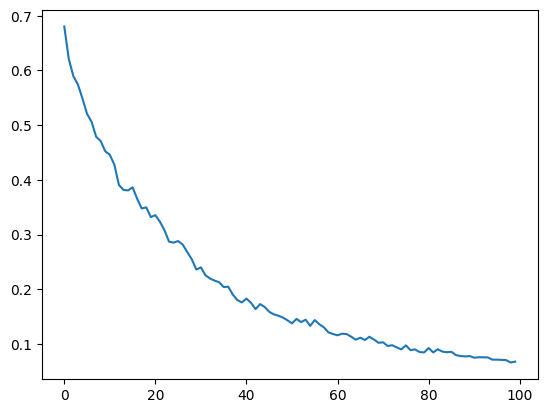

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
test_dataset = SentimentDataset(X_test_rnn, y_test_rnn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
predictions = []
original_labels = []

with torch.no_grad():
  model_rnn.eval()
  for texts, labels in test_loader:
    current_batch_size = texts.size(0)
    hidden = model_rnn.init_hidden(current_batch_size)
    line_tensor = texts.to(device)
    category_tensor = labels.long().to(device)
    output, hidden = model_rnn(line_tensor.unsqueeze(1), hidden)
    output = output.squeeze(1)

    _, predicted_labels = torch.max(output, dim=1) #выдаёт наиболее вероятную категорию
    predictions.extend(predicted_labels.numpy())
    original_labels.extend(labels.numpy())

In [ ]:
print(classification_report(original_labels, predictions))

              precision    recall  f1-score   support

           0       0.53      0.47      0.50        19
           1       0.60      0.65      0.62        23

    accuracy                           0.57        42
   macro avg       0.56      0.56      0.56        42
weighted avg       0.57      0.57      0.57        42



если честно, я сначала пробовала обычную RNN, и значения были выше)))

## Transformers (2 балла)

За использование другой базовой модели может быть начислен 1 дополнительный балл.

In [ ]:
! pip install transformers[torch]

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW #пришлось поменять откуда импортировать, потому что AdamW из transformers was deprecated

model_checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)
model_tf = DistilBertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
encoded_labels_for_tf = [LABELS[label] for label in df['Label'].tolist()]

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(df['Text'].tolist(),
                                                                encoded_labels_for_tf,
                                                                stratify=encoded_labels_for_tf,
                                                                test_size=0.2)

In [ ]:
import random

In [ ]:
optimizer_tf = optim.AdamW(model_tf.parameters(), lr=3e-4)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_encodings = tokenizer(X_train_tf, truncation=True, padding=True)
test_encodings = tokenizer(X_test_tf, truncation=True, padding=True)

train_labels = torch.tensor(y_train_tf, dtype=torch.long)
test_labels = torch.tensor(y_test_tf, dtype=torch.long)


train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                            torch.tensor(test_encodings['attention_mask']),
                            test_labels)

In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#код выполняется около 5 мин
epochs = 10
losses_tf = []

for epoch in range(epochs):

  model_tf.train()

  epoch_loss = 0

  for batch in train_loader:
      # ВАШ КОД ЗДЕСЬ
      optimizer_tf.zero_grad()

      res_tf = model_tf(batch[0].to(device), attention_mask=batch[1].to(device), labels=batch[2].to(device))
      #print(res_tf)
      epoch_loss += res_tf.loss.item()

      #backward pass & optimiser step
      res_tf.loss.backward()
      optimizer_tf.step()

  losses_tf.append(epoch_loss / len(train_loader))

  print(f"epoch {epoch}, loss: {epoch_loss / len(train_loader)}")


epoch 0, loss: 0.5482675351879813
epoch 1, loss: 0.2918808297677474
epoch 2, loss: 0.1834856986322186
epoch 3, loss: 0.044979235623031855
epoch 4, loss: 0.09724315867589955
epoch 5, loss: 0.16156161366961896
epoch 6, loss: 0.25396535477854987
epoch 7, loss: 0.16437339748848567
epoch 8, loss: 0.09987261586568573
epoch 9, loss: 0.07079001858999784


In [ ]:
losses_tf

[0.5482675351879813,
 0.2918808297677474,
 0.1834856986322186,
 0.044979235623031855,
 0.09724315867589955,
 0.16156161366961896,
 0.25396535477854987,
 0.16437339748848567,
 0.09987261586568573,
 0.07079001858999784]

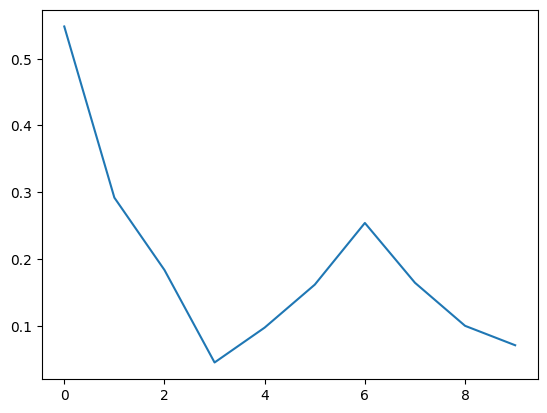

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_tf)

In [ ]:
predictions = []
probabilities = []
original_labels = []

with torch.no_grad():

  model_tf.eval() #больше веса менять не надо

  #for test_text, test_label in list(zip(X_test_tf, y_test_tf)):
  for batch in test_loader: #у нас же уже был test_loader, не поняла, зачем тут было делать zip
    # ВАШ КОД ЗДЕСЬ
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device) #true labels

    res_test_tf = model_tf(input_ids, attention_mask=attention_mask)
    pred_labels_logits = res_test_tf.logits
    probs_tf = torch.softmax(pred_labels_logits, dim=1)
    pred_labels = torch.argmax(pred_labels_logits, dim=1)

    #extend
    probabilities.extend(probs_tf.cpu().numpy())
    predictions.extend(pred_labels.cpu().numpy())
    original_labels.extend(labels.cpu().numpy())




In [ ]:
from sklearn.metrics import classification_report
print(classification_report(original_labels, predictions))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72        19
           1       0.76      0.83      0.79        23

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.76        42
weighted avg       0.76      0.76      0.76        42



In [ ]:
print(torch.mean(probs_tf, dim=0)) #в первый раз, когда запустила, 0 класс не предсказывался совсем, а сейчас всё норм...

tensor([0.3156, 0.6844])


## **То же самое, только с Т5**




(и с другим размером батча и кол-вом эпох)

In [ ]:
from transformers import T5Tokenizer, T5ForSequenceClassification
from torch.optim import AdamW #пришлось поменять откуда импортировать, потому что AdamW из transformers was deprecated

model_checkpoint_t5 = "t5-base"
tokenizer_t5 = T5Tokenizer.from_pretrained(model_checkpoint_t5)
model_tf_t5 = T5ForSequenceClassification.from_pretrained(model_checkpoint_t5, num_labels=2).to(device)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X_train_tf_t5, X_test_tf_t5, y_train_tf_t5, y_test_tf_t5 = train_test_split(df['Text'].tolist(),
                                                                encoded_labels_for_tf,
                                                                stratify=encoded_labels_for_tf,
                                                                test_size=0.2)

In [ ]:
optimizer_tf_t5 = optim.AdamW(model_tf_t5.parameters(), lr=3e-4)

In [ ]:
train_encodings_t5 = tokenizer_t5(X_train_tf_t5, truncation=True, padding=True)
test_encodings_t5 = tokenizer_t5(X_test_tf_t5, truncation=True, padding=True)

train_labels_t5 = torch.tensor(y_train_tf_t5, dtype=torch.long)
test_labels_t5 = torch.tensor(y_test_tf_t5, dtype=torch.long)


train_dataset_t5 = TensorDataset(torch.tensor(train_encodings_t5['input_ids']),
                              torch.tensor(train_encodings_t5['attention_mask']),
                              train_labels_t5)
test_dataset_t5 = TensorDataset(torch.tensor(test_encodings_t5['input_ids']),
                            torch.tensor(test_encodings_t5['attention_mask']),
                            test_labels_t5)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
batch_size_t5 = 8

train_loader_t5 = DataLoader(train_dataset_t5, batch_size=batch_size_t5, shuffle=True)
test_loader_t5 = DataLoader(test_dataset_t5, batch_size=batch_size_t5, shuffle=False)

код ниже выполняется долго!!!

In [ ]:
epochs_t5 = 6 #cначала было 15, но потом стало понятно, что после 6 эпохи лосс остаётся +- одним и тем же
losses_tf_t5 = []

for epoch in range(epochs_t5):

  model_tf_t5.train()

  epoch_loss = 0

  for batch in train_loader_t5:
      # ВАШ КОД ЗДЕСЬ
    optimizer_tf_t5.zero_grad()

    res_tf_t5 = model_tf_t5(batch[0].to(device), attention_mask=batch[1].to(device), labels=batch[2].to(device)) #передаем входы на видеокарту
      #print(res_tf)
    epoch_loss += res_tf_t5.loss.item()

      #backward pass & optimiser step
    res_tf_t5.loss.backward()
    optimizer_tf_t5.step()

  losses_tf_t5.append(epoch_loss / len(train_loader_t5))

  print(f"epoch {epoch}, loss: {epoch_loss / len(train_loader_t5)}")


epoch 0, loss: 0.6464297019300007
epoch 1, loss: 0.2429863621170322
epoch 2, loss: 0.06038160379033625
epoch 3, loss: 0.04082637984538451
epoch 4, loss: 0.020158276092150203
epoch 5, loss: 0.00571366374441866


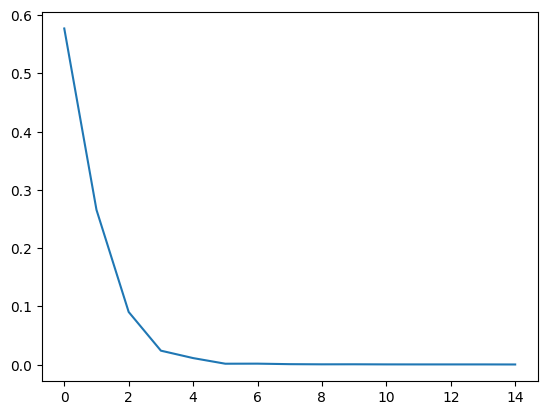

In [ ]:
plt.plot(losses_tf_t5)

In [ ]:
predictions_t5 = []
probabilities_t5 = []
original_labels_t5 = []

with torch.no_grad():

  model_tf_t5.eval() #больше веса менять не надо

  #for test_text, test_label in list(zip(X_test_tf, y_test_tf)):
  for batch in test_loader_t5: #у нас же уже был test_loader, не поняла, зачем тут было делать zip
    # ВАШ КОД ЗДЕСЬ
    input_ids_t5 = batch[0].to(device)
    attention_mask_t5 = batch[1].to(device)
    labels_t5 = batch[2].to(device) #true labels

    res_test_tf_t5 = model_tf_t5(input_ids_t5, attention_mask=attention_mask_t5)
    pred_labels_logits_t5 = res_test_tf_t5.logits
    probs_tf_t5 = torch.softmax(pred_labels_logits_t5, dim=1)
    pred_labels_t5 = torch.argmax(pred_labels_logits_t5, dim=1)

    #extend
    probabilities_t5.extend(probs_tf_t5.cpu().numpy())
    predictions_t5.extend(pred_labels_t5.cpu().numpy())
    original_labels_t5.extend(labels_t5.cpu().numpy())

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [ ]:
print(classification_report(original_labels_t5, predictions_t5))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.95      0.83      0.88        23

    accuracy                           0.88        42
   macro avg       0.88      0.89      0.88        42
weighted avg       0.89      0.88      0.88        42

